# XGBoost Base Model

In [ ]:
pip install xgboost

In [ ]:
pip install --upgrade xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import mlflow
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


warnings.filterwarnings("ignore")

# Read Data and Setup MLFLow

In [3]:
# read input data
churn = pd.read_csv("./data/churn.txt")
pd.set_option("display.max_columns", 500)

In [4]:
churn.shape

(5000, 21)

In [5]:
churn.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,773.791400,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,63.470888,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,657.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,736.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,778.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,806.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,878.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


In [6]:
# Set-up MLFlow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("xgboost-experiment")

<Experiment: artifact_location='/home/ubuntu/Project-XGBoost-MLOps/MLFlow/mlruns/1', creation_time=1689999897836, experiment_id='1', last_update_time=1689999897836, lifecycle_stage='active', name='xgboost-experiment', tags={}>

# Data Analysis

By modern standards, it’s a relatively small dataset, with only 5,000 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute: the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

col_0,% observations
State,
AK,0.0170
AL,0.0200
AR,0.0220
AZ,0.0180
CA,0.0208
CO,0.0182
CT,0.0178
DC,0.0224
DE,0.0182


col_0,% observations
Phone,
100-2030,0.0002
100-2118,0.0002
100-3505,0.0002
100-5224,0.0002
101-3371,0.0002
...,...
999-3178,0.0002
999-5498,0.0002
999-5816,0.0002


col_0,% observations
Int'l Plan,
no,0.5014
yes,0.4986


col_0,% observations
VMail Plan,
no,0.4976
yes,0.5024


col_0,% observations
Churn?,
False.,0.5004
True.,0.4996


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,773.791400,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,63.470888,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,657.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,736.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,778.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,806.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,878.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


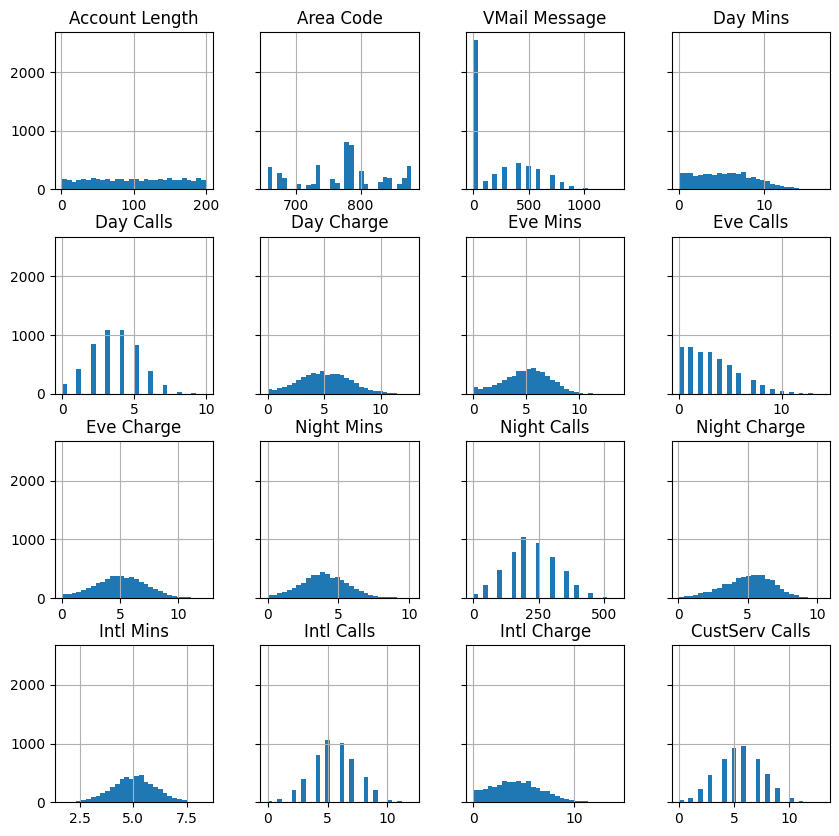

In [16]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=["object"]).columns:
    display(pd.crosstab(index=churn[column], columns="% observations", normalize="columns"))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that:
- `State` appears to be quite evenly distributed.
- `Phone` takes on too many unique values to be of any practical use.  It's possible that parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like `gaussianity`.  `VMail Message` is a notable exception (and `Area Code` showing up as a feature we should convert to non-numeric).

In [7]:
churn = churn.drop("Phone", axis=1)
churn["Area Code"] = churn["Area Code"].astype(object)


Next let's look at the relationship between each of the features and our target variable.

Churn?,False.,True.
State,,
AK,0.015588,0.018415
AL,0.021583,0.018415
AR,0.022782,0.021217
AZ,0.015588,0.020416
CA,0.020384,0.021217
CO,0.018785,0.017614
CT,0.015588,0.020016
DC,0.022382,0.022418
DE,0.018385,0.018014


Churn?,False.,True.
Area Code,,
657,0.037170,0.036829
658,0.022782,0.021217
659,0.015588,0.020416
676,0.020384,0.021217
677,0.018785,0.017614
678,0.015588,0.020016
686,0.040767,0.040432
707,0.019984,0.015612
716,0.017986,0.015212


Churn?,False.,True.
Int'l Plan,,
no,0.5,0.502802
yes,0.5,0.497198


Churn?,False.,True.
VMail Plan,,
no,0.496403,0.498799
yes,0.503597,0.501201


Account Length


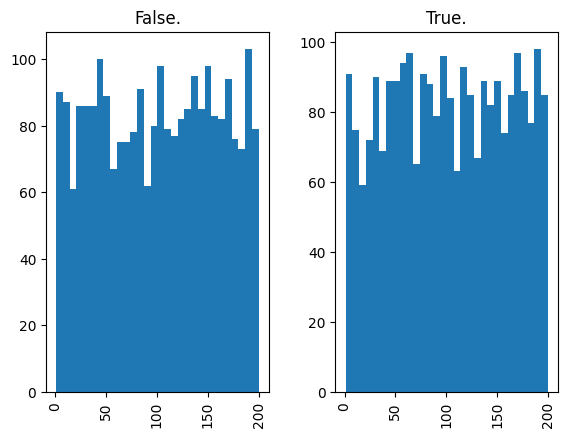

VMail Message


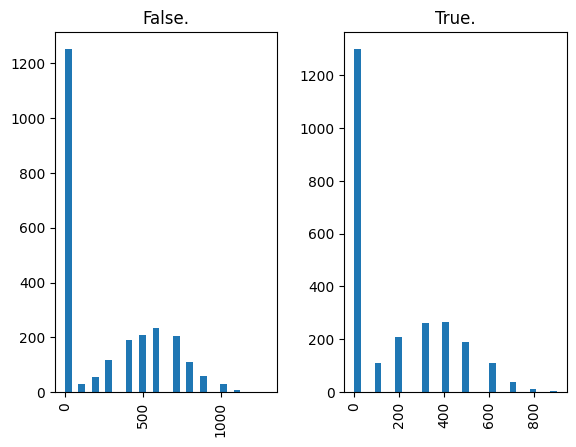

Day Mins


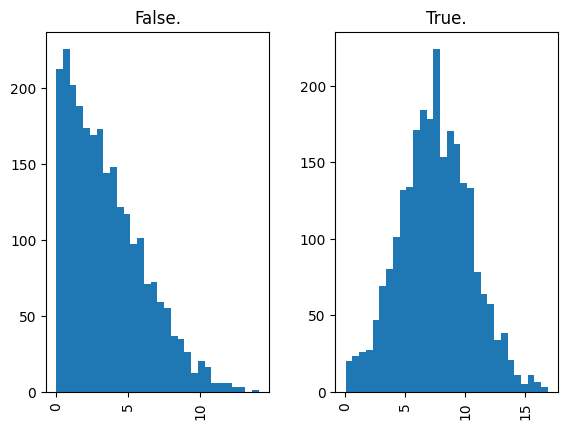

Day Calls


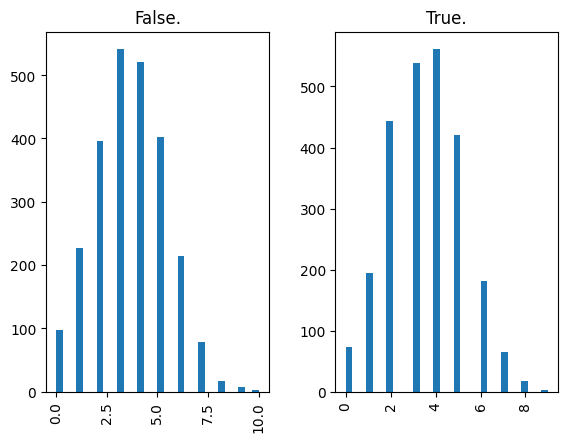

Day Charge


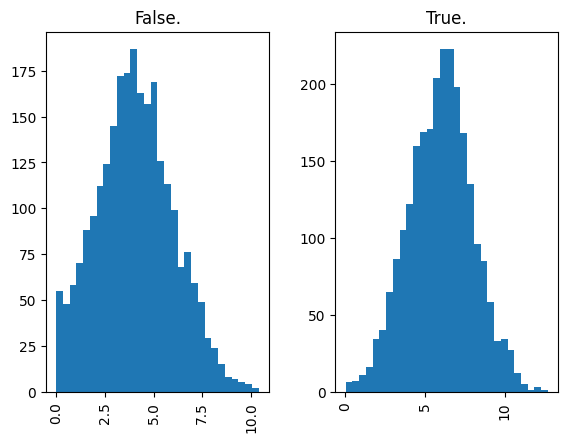

Eve Mins


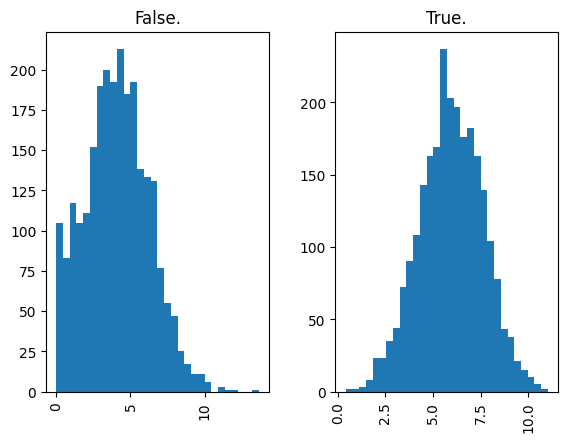

Eve Calls


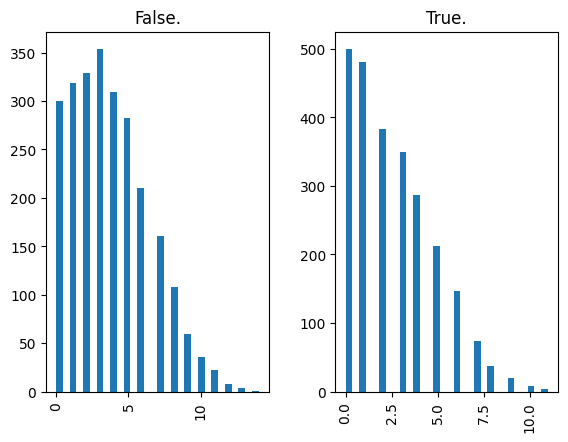

Eve Charge


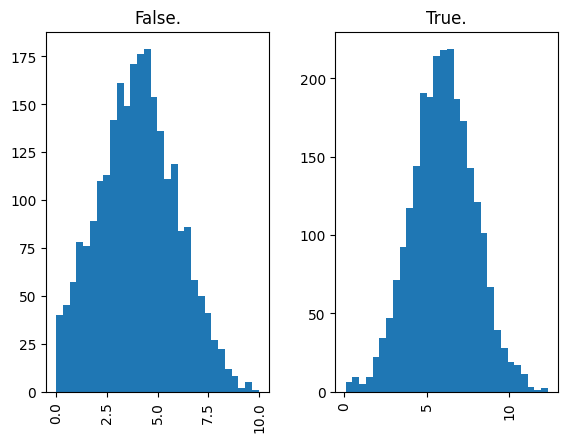

Night Mins


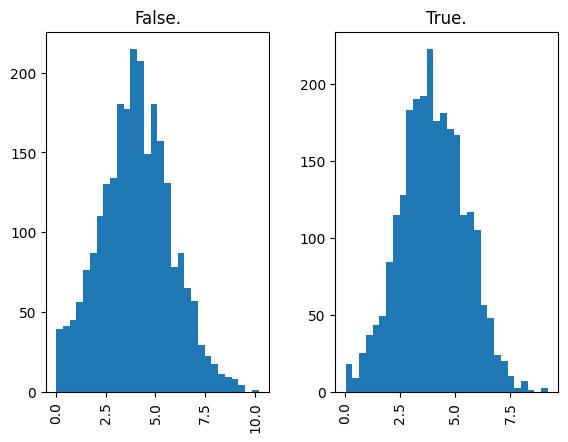

Night Calls


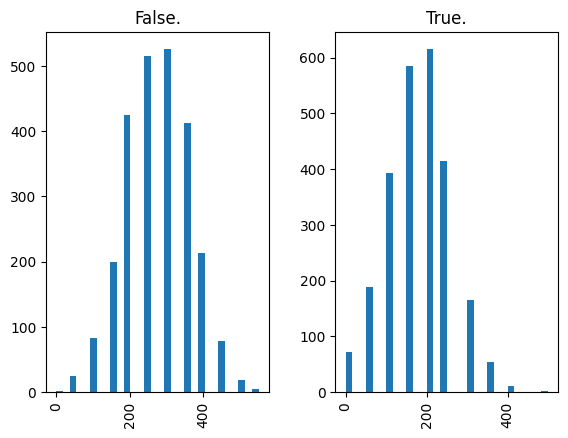

Night Charge


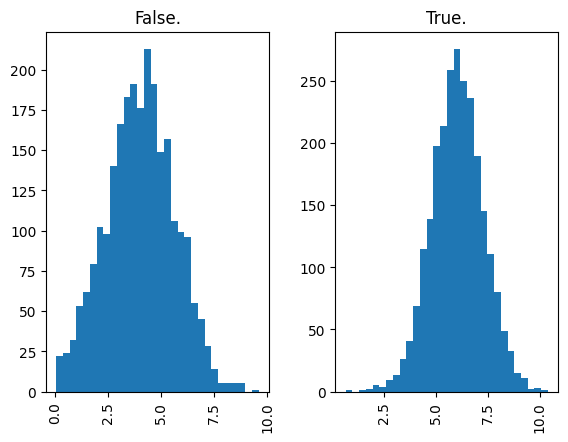

Intl Mins


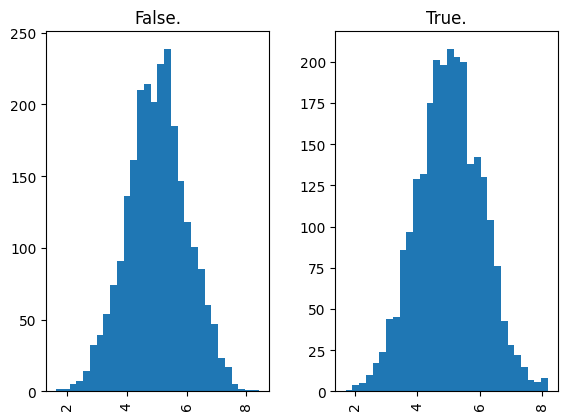

Intl Calls


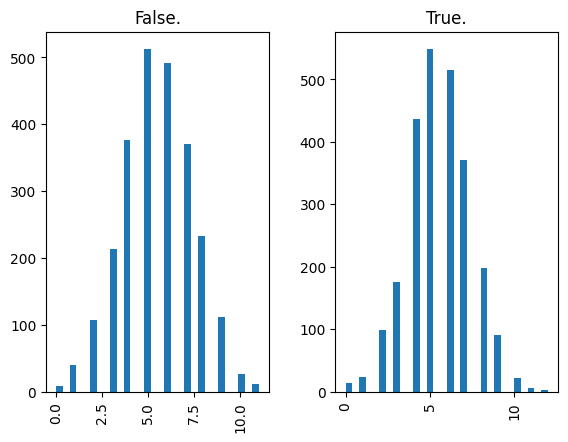

Intl Charge


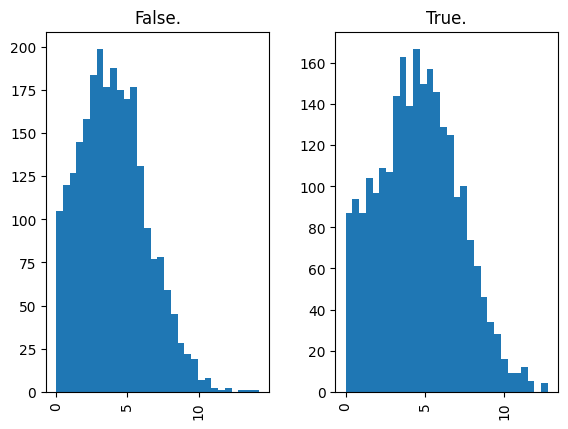

CustServ Calls


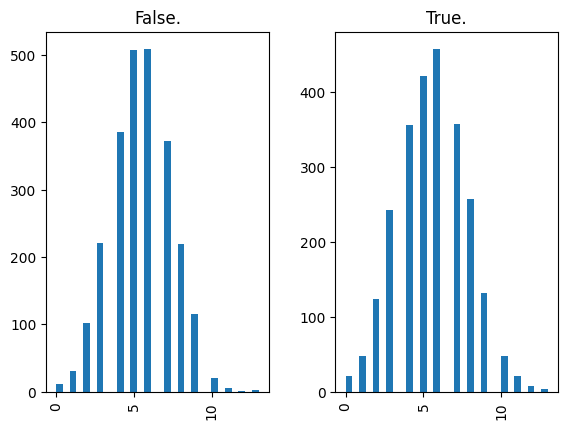

In [18]:
for column in churn.select_dtypes(include=["object"]).columns:
    if column != "Churn?":
        display(pd.crosstab(index=churn[column], columns=churn["Churn?"], normalize="columns"))

for column in churn.select_dtypes(exclude=["object"]).columns:
    print(column)
    hist = churn[[column, "Churn?"]].hist(by="Churn?", bins=30)
    plt.show()

We see several features that essentially have 100% correlation with one another.  Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias.  Let's remove one feature from each of the highly correlated pairs: `Day Charge` from the pair with `Day Mins`, `Night Charge` from the pair with `Night Mins`, `Intl Charge` from the pair with `Intl Mins`:

In [8]:
churn = churn.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

In [20]:
churn.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
0,PA,163,806,no,yes,300,8.162204,3,3.933035,4,4.065759,100,4.928160,6,3,True.
1,SC,15,836,yes,no,0,10.018993,4,2.325005,0,7.141040,200,3.221748,6,8,False.
2,MO,131,777,no,yes,300,4.708490,3,4.537466,3,5.363235,100,7.139023,2,4,False.
3,WY,75,878,yes,yes,700,1.268734,3,2.528748,5,3.773586,450,2.245779,6,6,False.
4,WY,146,878,yes,no,0,2.696177,3,6.015337,3,3.751673,250,6.905545,4,6,True.


# Train Model

In [9]:
# Extract feature and target arrays
X, y = churn.drop('Churn?', axis=1), churn[['Churn?']]

In [10]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

In [23]:
X.dtypes

State             category
Account Length       int64
Area Code         category
Int'l Plan        category
VMail Plan        category
VMail Message        int64
Day Mins           float64
Day Calls            int64
Eve Mins           float64
Eve Calls            int64
Night Mins         float64
Night Calls          int64
Intl Mins          float64
Intl Calls           int64
CustServ Calls       int64
dtype: object

In [11]:
y['Churn?'] = y['Churn?'].replace({'True.': 1, 'False.': 0})

In [25]:
y.dtypes

Churn?    int64
dtype: object

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
X_test.head()

In [ ]:
y_test.dtypes

In [ ]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',tree_method="hist",enable_categorical=True)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

In [13]:
mlflow.xgboost.autolog()

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [36]:
# specify parameters via map
params = {'max_depth': None, 'eval_metric' : 'mlogloss', 'tree_method' : "hist", 'eta':1, 'objective':'binary:logistic'}
num_round = 2

# train model 
def objective(params):
    
    with mlflow.start_run():

        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            evals=[(dtest,"test")],
            early_stopping_rounds=50
        )

        # make prediction
        y_pred_prob = booster.predict(dtest)
        y_pred = (y_pred_prob >= 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.autolog()

        # Define the loss as the negative value of accuracy for minimization
        loss = -accuracy

        return {'loss': loss, 'status': STATUS_OK}

In [32]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'binary:logistic',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

NameError: name 'objective' is not defined

# Selecting the best model

In [25]:
# with mlflow.start_run():

best_params = {
    'learning_rate'	: 0.2611886716276454,
    'max_depth' : 39,
    'min_child_weight' : 4.490391995734931,
    'objective' : 'binary:logistic',
    'reg_alpha' : 0.044567672488398144,
    'reg_lambda' : 0.11968534468462336,
    'seed' : 42
}

mlflow.log_params(best_params)

booster = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtest,"test")],
    early_stopping_rounds=50
)

# make prediction
y_pred_prob = booster.predict(dtest)
y_pred = (y_pred_prob >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
mlflow.log_metric("accuracy", accuracy)

mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

# Define the loss as the negative value of accuracy for minimization
loss = -accuracy

   


[0]	test-logloss:0.54282
[1]	test-logloss:0.45312
[2]	test-logloss:0.39377
[3]	test-logloss:0.35153
[4]	test-logloss:0.31902
[5]	test-logloss:0.29640
[6]	test-logloss:0.27763
[7]	test-logloss:0.26303
[8]	test-logloss:0.25358
[9]	test-logloss:0.24204
[10]	test-logloss:0.23418
[11]	test-logloss:0.22692
[12]	test-logloss:0.22027
[13]	test-logloss:0.21447
[14]	test-logloss:0.21178
[15]	test-logloss:0.20846
[16]	test-logloss:0.20704
[17]	test-logloss:0.20525
[18]	test-logloss:0.20439
[19]	test-logloss:0.20348
[20]	test-logloss:0.20258
[21]	test-logloss:0.20273
[22]	test-logloss:0.20108
[23]	test-logloss:0.20087
[24]	test-logloss:0.19957
[25]	test-logloss:0.19875
[26]	test-logloss:0.19647
[27]	test-logloss:0.19640
[28]	test-logloss:0.19651
[29]	test-logloss:0.19517
[30]	test-logloss:0.19424
[31]	test-logloss:0.19269
[32]	test-logloss:0.19332
[33]	test-logloss:0.19301
[34]	test-logloss:0.19244
[35]	test-logloss:0.19233
[36]	test-logloss:0.19108
[37]	test-logloss:0.19182
[38]	test-logloss:0.19

2023/07/23 22:27:41 WARNING mlflow.xgboost: Failed to infer model signature: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:State: category, Area Code: category, Int'l Plan: category, VMail Plan: category


# Appendix

In [ ]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [ ]:
# Define hyperparameters
# objective : "reg:squarederror" - linear regression
# objective : "binary:logistic" - binary classification
# objective : "multi:softprob" - multi-class classification
# "tree_method": "gpu_hist" - GPU
# "tree_method": "hist" - CPU

params = {"objective": "binary:logistic", "tree_method": "hist"}

In [ ]:
n = 10000
# evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
  params=params,
  dtrain=dtrain_reg,
  num_boost_round=n,
)

In [ ]:
n = 10000
# evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
  params=params,
  dtrain=dtrain_reg,
  num_boost_round=n,
  evals=evals, # Show rmse for train and validation
  verbose_eval=50, # Every ten rounds
  early_stopping_rounds=50 # Activate early stopping
)

In [ ]:
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_reg)

In [ ]:
preds

In [ ]:
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")